In [1]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
from shapely.geometry import box
import numpy as np

In [2]:
cd /home/op/network_manila

/home/op/network_manila


In [3]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [4]:
G_clip = nx.read_gpickle('data_osm_raw/manila_clean_clipped.pickle')

In [4]:
G_clip_disrupted = nx.read_gpickle('data_osm_raw/manila_clean_clipped_disrupted.pickle')

## prepare origin and destination points

In [6]:
#get administrative boundary of metro manila
philippines_adm2 = gpd.read_file("boundaries/philippines_adm2.geojson")
philippines_adm2 = philippines_adm2.to_crs({'init':'epsg:4326'})
manila = philippines_adm2[philippines_adm2.ADM2_NAME=="Metropolitan Manila"]

In [7]:
manila = manila.to_crs(crs_manila)

In [8]:
def create_point_grid(gdf, distance, crs):
    """
    this function creates a grid of points with equal distance within the space described by the geodataframe
    important: the crs passed as param has to be in accordance with the distance specified
    :param gdf: a geodataframe
    :param distance: distance between points. measured in crs of gdf
    :param crs: the crs in which the distance is measured to return the points
    :returns: a geodataframe of points
    """

    gdf_copy = gdf.copy()
    gdf_copy = gdf_copy.to_crs(crs)
    minx, miny, maxx, maxy = gdf_copy.bounds.values[0]
    poly = gdf_copy.unary_union
    x = minx
    points = []
    while x < maxx:
        y = miny
        while y < maxy:
            point = Point(x,y)
            #check whether point is within poly and keep only if this is the case
            if poly.intersects(point):
                points.append(point)
            y = y + distance
        x = x + distance
    df = pd.DataFrame({'geometry':points})  
    points_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs)
    return points_gdf

In [10]:
box_geom = box(121.05, 14.6, 121.1, 14.65)
df = pd.DataFrame({"geometry":box_geom}, index=[0])
box_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs_global)

In [11]:
#clipped area only
origin_points = create_point_grid(box_gdf, distance = 500, crs = crs_manila)

In [12]:
origin_points = origin_points.to_crs(crs_global)
manila = manila.to_crs(crs_global)

In [13]:
hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")
hospitals = hospitals[hospitals.intersects(box_gdf.unary_union)]

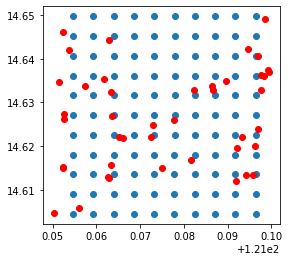

In [14]:
ax = origin_points.plot()
hospitals.plot(ax = ax, color='red')

## bind points to graph and calculate origin, destination matrices

In [15]:
origins_snapped = gn.pandana_snap(G_clip_disrupted, 
                                  origin_points, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1605: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1607: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [16]:
hospitals_snapped = gn.pandana_snap(G_clip_disrupted, 
                                  hospitals, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




In [31]:
origins_snapped

,geometry,NN,NN_dist
0,POINT (121.05463 14.60452),1260,66.064526
1,POINT (121.05463 14.60904),3620,6.694454
2,POINT (121.05463 14.61356),2684,46.264326
3,POINT (121.05463 14.61808),3850,48.801641
4,POINT (121.05464 14.62259),649,40.408544
...,...,...,...
105,POINT (121.09641 14.63162),1726,62.879071
106,POINT (121.09641 14.63614),4061,42.931384
107,POINT (121.09641 14.64066),207,14.378469
108,POINT (121.09642 14.64518),216,8.308062


In [17]:
origin_nodes = list(origins_snapped.NN)
hospital_nodes = list(hospitals_snapped.NN)

In [18]:
len(origin_nodes), len(hospital_nodes)

(110, 43)

In [ ]:
walk_speed = 4.5/3.6 #in meters per second

In [58]:
OD = gn.calculate_OD(G_clip_disrupted, origins= origin_nodes, destinations = hospital_nodes, 
                  fail_value = 999999999, weight = 'time', weighted_origins = False)
#in seconds

## add time to walk from origin point to nearest node
distance_to_node = np.asarray(origins_snapped.NN_dist)[:, np.newaxis]
time_to_node = distance_to_node * walk_speed
#each row of OD matrix is from same origin, so we can just use numpy's broadcasting
OD = OD + time_to_node

## add time to walk from destination node to POI
distance_from_node = np.asarray(hospitals_snapped.NN_dist)[:, np.newaxis]
time_from_node = distance_from_node * walk_speed
#each column of OD matrix is same destination, so we transpose times and then add using numpy's broadcasting
OD = OD + time_from_node.T

In [59]:
OD_disrupted = gn.calculate_OD(G_clip_disrupted, origins= origin_nodes, destinations = hospital_nodes, 
                  fail_value = 999999999, weight = 'time_disrupted', weighted_origins = False)
#in seconds

## add time to walk from origin point to nearest node
distance_to_node = np.asarray(origins_snapped.NN_dist)[:, np.newaxis]
time_to_node = distance_to_node * walk_speed
#each row of OD matrix is from same origin, so we can just use numpy's broadcasting
OD_disrupted = OD_disrupted + time_to_node

## add time to walk from destination node to POI
distance_from_node = np.asarray(hospitals_snapped.NN_dist)[:, np.newaxis]
time_from_node = distance_from_node * walk_speed
#each column of OD matrix is same destination, so we transpose times and then add using numpy's broadcasting
OD_disrupted = OD_disrupted + time_from_node.T

In [60]:
OD.shape , OD_disrupted.shape

((110, 43), (110, 43))

In [61]:
min_distance = np.min(OD, axis = 1)
min_distance_disrupted = np.min(OD_disrupted, axis = 1)

len(min_distance)

110

In [62]:
min_distance_disrupted[min_distance_disrupted > 99999999] = np.NaN

In [63]:
origin_points['min_hospital_distance_seconds'] = min_distance
origin_points['min_hospital_distance_seconds_disrupted'] = min_distance_disrupted


origin_points.head()

,geometry,min_hospital_distance_seconds,min_hospital_distance_seconds_disrupted
0,POINT (121.05463 14.60452),128.952581,128.952581
1,POINT (121.05463 14.60904),148.339154,148.339154
2,POINT (121.05463 14.61356),163.473741,163.473741
3,POINT (121.05463 14.61808),168.717724,168.717724
4,POINT (121.05464 14.62259),151.636129,151.636129


## visualize results

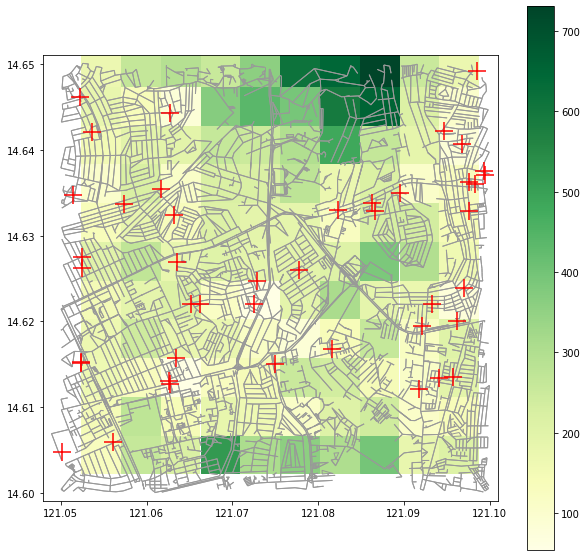

<Figure size 432x288 with 0 Axes>

In [64]:
G_clip_disrupted.graph.update( {'crs' : crs_global} )
G_clip_disrupted.graph.update( {'name' : 'manila'} )
fig, ax = ox.plot_graph(G_clip_disrupted, fig_height=10, axis_off=False, show=False, node_color="None" )
origin_points.plot(ax=ax, cmap="YlGn", column="min_hospital_distance_seconds", 
                   marker = "s", markersize=1500, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="red", marker="+", markersize=300, zorder=2)
fig

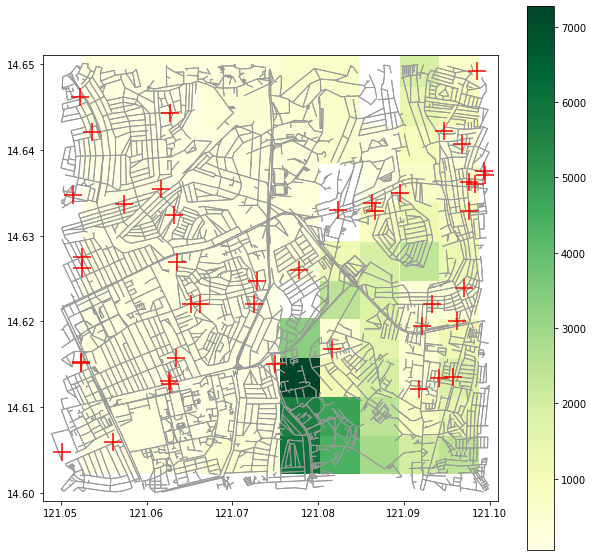

<Figure size 432x288 with 0 Axes>

In [65]:
G_clip_disrupted.graph.update( {'crs' : crs_global} )
G_clip_disrupted.graph.update( {'name' : 'manila'} )
fig1, ax = ox.plot_graph(G_clip_disrupted, fig_height=10, axis_off=False, show=False, node_color="None" )
origin_points.plot(ax=ax, cmap="YlGn", column="min_hospital_distance_seconds_disrupted", 
                   marker = "s", markersize=1500, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="red", marker="+", markersize=300, zorder=2)
fig1

In [70]:
origin_points["increase_sec"] = (origin_points['min_hospital_distance_seconds_disrupted'] - 
                                 min_distance_disrupted['min_hospital_distance_seconds'])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [71]:
origin_points["increase_perc"] = ((origin_points['min_hospital_distance_seconds_disrupted'] - 
                                   min_distance_disrupted['min_hospital_distance_seconds'])/
                                  min_distance_disrupted['min_hospital_distance_seconds'])



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# results are majorly determined by choice of liqeufaction speed - see graph 